In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from nltk.corpus import stopwords
from scipy.stats import boxcox
from scipy import sparse
import seaborn as sns
import pandas as pd
import numpy as np
import _pickle as cPickle
import emoji
import nltk
import re

import matplotlib.pyplot as mp
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from insultFunctions import *

#-----Read in data-----#
annotations = pd.read_csv('/Users/degrave/DataScience/SafeSocial/data/perspectives/' + \
                                        'toxicity_annotations.tsv', sep='\t')
scores = annotations.groupby('rev_id')['toxicity'].mean()

score_id = scores.index.tolist()
score_val = scores.values

comments = pd.read_csv('/Users/degrave/DataScience/SafeSocial/data/perspectives/' + \
                                            'toxicity_annotated_comments.tsv', sep='\t')
comments = comments[comments['rev_id'].isin(score_id)]
comments.reset_index(drop=True, inplace=True)

comments['target'] = score_val
df = comments[comments['split'] == 'dev'][['comment', 'target']]

In [31]:
df['comment'] = df['comment'].apply(preProcess)

df = df[df['comment'] != '']

df['ratioPunc']  = df['comment'].apply(ratioPunc)
df['ratioHash']  = df['comment'].apply(ratioHash)
df['ratioCaps']  = df['comment'].apply(ratioCaps)
df['ratioEmoji'] = df['comment'].apply(ratioEmoji)

df['textPro'] = df['comment'].apply(replaceYou)
df['textPro'] = df['textPro'].apply(replaceBad)
df['textPro'] = df['textPro'].apply(replaceCont)
df['textPro'] = df['textPro'].apply(replaceMultPunc)
df['textPro'] = df['textPro'].apply(processTextInsult)

df = df[df['textPro'] != '']

df['avgWordLen']  = df['comment'].apply(avgWordLen)
df['ratioStop']   = df['textPro'].apply(ratioStop)
df['ratioAtuser'] = df['textPro'].apply(ratioAtuser)
df['ratioDirect'] = df['textPro'].apply(ratioDirect)
df['ratioBadWords'] = df['textPro'].apply(ratioBadWords)

df['firstDirectPos'] = df['textPro'].apply(firstDirectPos)
df['ratioDirectPos'] = df['textPro'].apply(ratioDirectPos)
df['firstBadWordPos'] = df['textPro'].apply(firstBadWordPos)
df['ratioBadWordPos'] = df['textPro'].apply(ratioBadWordPos)
df['distBadDirectPos'] = df['textPro'].apply(distBadDirectPos)

In [32]:
df.head()

,comment,target,ratioPunc,ratioHash,ratioCaps,ratioEmoji,textPro,avgWordLen,ratioStop,ratioAtuser,ratioDirect,ratioBadWords,firstDirectPos,ratioDirectPos,firstBadWordPos,ratioBadWordPos,distBadDirectPos
5,`:in an interpreted language your source code ...,0.1,0.042681,0.000482,0.0,0.0,in an interpreted language your source code is...,6.236090,0.442279,0.0,0.013493,0.001499,27,0.006820,191,0.048245,164
8,`- this is not ``creative``. those are the dic...,0.2,0.071700,0.000000,0.0,0.0,this is not creative those are the dictionary ...,6.142487,0.516049,0.0,0.029630,0.000000,133,0.059508,-1,-1.000000,-1
10,` can anyone provide any justification for the...,0.0,0.071926,0.000000,0.0,0.0,can anyone provide any justification for the s...,6.338235,0.357143,0.0,0.000000,0.000000,-1,-1.000000,-1,-1.000000,-1
13,"done. this entry is lond, i'll see about chopp...",0.1,0.064516,0.000000,0.0,0.0,done this entry is lond i will see about chopp...,5.166667,0.538462,0.0,0.000000,0.000000,-1,-1.000000,-1,-1.000000,-1
14,"note to eclecticology: hum, you just brought t...",0.0,0.017118,0.000000,0.0,0.0,note to eclecticology hum you just brought to ...,5.699187,0.540323,0.0,0.008065,0.000000,26,0.037736,-1,-1.000000,-1


In [33]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)

y_train = df_train['target'].values
y_test = df_test['target'].values

df_train.drop('target', axis=1, inplace=True)
df_train.reset_index(drop=True, inplace=True)

df_test.drop('target', axis=1, inplace=True)
df_test.reset_index(drop=True, inplace=True)

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [55]:
tvec = TfidfVectorizer(strip_accents='unicode', analyzer='char', ngram_range=(3,3), max_features=2000, norm=None,
                       stop_words=None, use_idf=True)

val_names = df_train.drop(['comment','textPro'], axis=1).columns

X_train_text = tvec.fit_transform(df_train['textPro'])
X_train_val = df_train[val_names].values
X_train = sparse.hstack([X_train_val, X_train_text]).tocsr()

X_test_text = tvec.transform(df_test['textPro'])
X_test_val = df_test[val_names].values
X_test = sparse.hstack([X_test_val, X_test_text]).tocsr()

In [56]:
from keras.models import Sequential, optimizers
from keras.layers import Dense, Dropout

np.random.seed()
model = None
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss='mean_absolute_error', optimizer=rmsprop, metrics=['accuracy'])
model.fit(X_train.toarray(), y_train, epochs=15, batch_size=100, validation_split=0.2, verbose=2)

predict = model.predict(X_test.toarray())

Train on 20556 samples, validate on 5140 samples
Epoch 1/15
1s - loss: 0.1113 - acc: 0.5834 - val_loss: 0.1058 - val_acc: 0.5858
Epoch 2/15
1s - loss: 0.0984 - acc: 0.5882 - val_loss: 0.1010 - val_acc: 0.5874
Epoch 3/15
1s - loss: 0.0937 - acc: 0.5881 - val_loss: 0.0936 - val_acc: 0.5879
Epoch 4/15
1s - loss: 0.0887 - acc: 0.5900 - val_loss: 0.0891 - val_acc: 0.5895
Epoch 5/15
1s - loss: 0.0859 - acc: 0.5900 - val_loss: 0.0876 - val_acc: 0.5889
Epoch 6/15
1s - loss: 0.0816 - acc: 0.5901 - val_loss: 0.0879 - val_acc: 0.5891
Epoch 7/15
1s - loss: 0.0778 - acc: 0.5909 - val_loss: 0.0868 - val_acc: 0.5895
Epoch 8/15
1s - loss: 0.0740 - acc: 0.5911 - val_loss: 0.0835 - val_acc: 0.5895
Epoch 9/15
1s - loss: 0.0715 - acc: 0.5915 - val_loss: 0.0838 - val_acc: 0.5897
Epoch 10/15
1s - loss: 0.0689 - acc: 0.5916 - val_loss: 0.0854 - val_acc: 0.5895
Epoch 11/15
1s - loss: 0.0674 - acc: 0.5914 - val_loss: 0.0837 - val_acc: 0.5895
Epoch 12/15
1s - loss: 0.0655 - acc: 0.5917 - val_loss: 0.0822 - val_

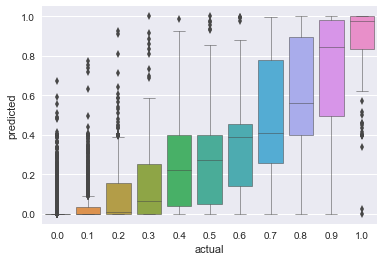

In [100]:
sns.boxplot(x=np.round(y_test,1), y=predict.ravel(), linewidth=0.5)
mp.ylabel('predicted')
mp.xlabel('actual')

In [75]:
tvec

TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2000, min_df=1,
        ngram_range=(3, 3), norm=None, preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents='unicode', sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [82]:
dest = '/Users/degrave/DataScience/SafeSocial/application/pkl_objects_8172017/'

model.save(dest + 'model_toxicity.h5')
cPickle.dump(tvec, open(os.path.join(dest, 'tvec_toxicity.pkl'), 'wb'), protocol=None)